#### About this repository:

The notebooks in this repository are meant to serve as comprehensive building blocks for establishing an algorithmic trading system. 
 
A number of sample trading strategies are included, along with methodologies to determine their robustness. Walk-Forward Analysis is one such well known technique, while Combinatorial Purged Cross Validation is a newer and more  rigorous methodology. Another useful and important concept is Meta Labelling, which predicts the probability of individual winning trades. All three techniques are utilized here to help improve the rigor of the systematic trading research process. 

Even though the methodologies presented in these notebooks can always be fine-tuned further, they are sophisticated enough to provide rigorous backtesting of any algorithmic trading strategy. After looking through this repository, one should gain an understanding of how algorithmic trading startegies are programmed and backtested. Identifying such strategies can simply be a matter of adapting algorithms found in research journals or trading websites; the aim of these notebooks is to determine a strategy's profitability and robustness. The final step of live trading a strategy should be merely trivial rewriting of a few lines of code in the Zipline version of the strategy. 


*Hoa Tuan Nguyen:* http://linkedin.com/in/hoatuannguyen/

## Pair Trading Strategy:

This notebook presents how to backtest a Pair Trading strategy with Zipline. Although ETH and BTC are no longer cointegrated, the merit of this notebook is more in showing how to program in Zipline a strategy that trades multiple securities. 

In [1]:
%load_ext zipline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from collections import OrderedDict
from datetime import datetime, timedelta
import pytz

import zipline
from zipline.api import *
from zipline.utils.always_open import AlwaysOpenCalendar

In [3]:
data = OrderedDict()

data['BTC'] = pd.read_csv('/Users/nguyentuanhoa/Downloads/Crypto/zipline/data/btc_2019_july20_2020.csv',index_col=0,parse_dates=True)
data['ETH'] = pd.read_csv('/Users/nguyentuanhoa/Downloads/Crypto/zipline/data/eth_2019_july_2020.csv',index_col=0,parse_dates=True)

muliplier = 100

data['BTC'].loc[:,'open':'low'] /= muliplier
data['BTC'].volume *= muliplier

panel = pd.Panel(data)
panel.minor_axis = ["open","high","low","close","volume"]
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)

In [13]:
def initialize(context):    
    set_benchmark(symbol('BTC'))
    context.sec1 = symbol('BTC')
    context.sec2 = symbol('ETH')
    
    context.lower_breached = False
    context.upper_breached = False
    
    context.times_breaches = 0
    context.take_profit = 0
    context.stopped_out = 0
    context.pos_ret = 0
    context.neg_ret = 0
    
    context.long_window = 3120
    context.short_window = 165
    context.std_multiplier = 2.3
    
    context.hedge_ratio = 28.583   # from calculating using the first 10 days of march 1, 2019
                                   # see Pair Trading Strategy Explore notebook for more details
    
    context.pt = .04
    context.sl = -.015

def handle_data(context, data):
    
    price_history = data.history(
        [context.sec1, context.sec2],
        fields='close',
        bar_count=context.long_window,
        frequency='1m'
    )
    
    spread = price_history[context.sec1] - context.hedge_ratio * price_history[context.sec2]
    
    slow_mva = spread.mean()
    slow_std = spread.std()
    fast_mva = spread[-context.short_window:].mean()
    
    upper = slow_mva + context.std_multiplier * slow_std
    lower = slow_mva - context.std_multiplier * slow_std
    
    current_price1 = price_history[context.sec1][-1]    
    current_price2 = price_history[context.sec2][-1]    
    
    sec1_amount = context.portfolio.positions[context.sec1].amount
    sec2_amount = context.portfolio.positions[context.sec2].amount
    has_pos = True if sec1_amount or sec2_amount else False
    
    order1 = get_open_orders(context.sec1)
    order2 = get_open_orders(context.sec2) 
    if len(order1)!=0 and len(order2) == 0:
        open_orders = order1[0].status==0
    elif len(order2)!=0 and len(order1) == 0:
        open_orders = order2[0].status==0
    elif len(order1)==0 and len(order2) == 0:
        open_orders = False
    else:
        open_orders = order1[0].status==0 or order2[0].status==0
    
    filled_price1 = context.portfolio.positions[context.sec1].cost_basis
    filled_price2 = context.portfolio.positions[context.sec2].cost_basis
   
    # short the spread
    if fast_mva > upper and not context.upper_breached:
        context.upper_breached = True
        context.times_breaches += 1
    elif not open_orders and not has_pos and context.upper_breached and fast_mva <= upper:
        order_target_percent(context.sec1, -1)   
        order_target_percent(context.sec2, 1)    # find out in what order these two orders executed
        context.upper_breached = False
    
    # long the spread
    if fast_mva < lower and not context.lower_breached:
        context.lower_breached = True
        context.times_breaches += 1
    elif not open_orders and not has_pos and context.lower_breached and fast_mva >= lower:
        order_target_percent(context.sec1, 1)    
        order_target_percent(context.sec2, -1)   # find out in what order these two orders executed
        context.lower_breached = False
     
    # take profits or stop loss for short spread trades
    elif not open_orders and sec1_amount<0:
        pc1 = (filled_price1-current_price1)/filled_price1
        pc2 = (current_price2-filled_price2)/filled_price2
        prct_changed = pc1 + pc2
        if fast_mva <= slow_mva:
            order_target_percent(context.sec1, 0)
            order_target_percent(context.sec2, 0)
            if prct_changed > 0:
                context.pos_ret += 1
            else:
                context.neg_ret += 1
        else:
            if prct_changed >= context.pt:
                order_target_percent(context.sec1, 0)
                order_target_percent(context.sec2, 0)
                context.take_profit += 1
                context.pos_ret += 1
            elif prct_changed <= context.sl:
                order_target_percent(context.sec1, 0)
                order_target_percent(context.sec2, 0)
                context.stopped_out += 1
                context.neg_ret += 1
    
    # take profits or stop loss for long spread trades
    elif not open_orders and sec1_amount>0:
        pc1 = (current_price1-filled_price1)/filled_price1
        pc2 = (filled_price2-current_price2)/filled_price2
        prct_changed = pc1 + pc2
        if fast_mva >= slow_mva:
            order_target_percent(context.sec1, 0)
            order_target_percent(context.sec2, 0)
            if prct_changed > 0:
                context.pos_ret += 1
            else:
                context.neg_ret += 1
        else:
            if prct_changed >= context.pt:
                order_target_percent(context.sec1, 0)
                order_target_percent(context.sec2, 0)
                context.take_profit += 1
                context.pos_ret += 1
            elif prct_changed <= context.sl:
                order_target_percent(context.sec1, 0)
                order_target_percent(context.sec2, 0)
                context.stopped_out += 1
                context.neg_ret += 1
        
    # reset bands breached flags if price within range
    elif fast_mva > lower and fast_mva < upper and context.upper_breached or context.lower_breached:
        context.lower_breached = False
        context.upper_breached = False
        
    record(times_breached = context.times_breaches, stopped_out = context.stopped_out, 
           take_profits = context.take_profit, pos_ret = context.pos_ret, neg_ret = context.neg_ret)

In [18]:
perf = zipline.run_algorithm(start=datetime(2019, 3, 1, 0, 0, 0, 0, pytz.utc),
                      end=datetime(2019, 6, 30, 0, 0, 0, 0, pytz.utc),
                      initialize=initialize,
                      handle_data=handle_data,
                      trading_calendar=AlwaysOpenCalendar(),
                      capital_base=20000,
                      data_frequency ='minute',
                      data=panel)

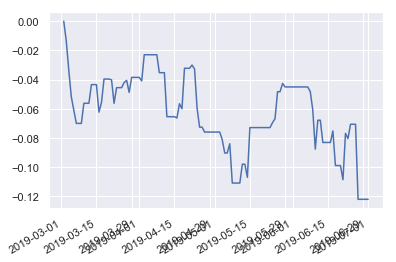

In [19]:
perf.algorithm_period_return.plot()

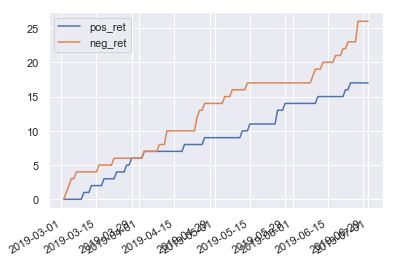

In [21]:
perf.pos_ret.plot()
perf.neg_ret.plot()
plt.legend()

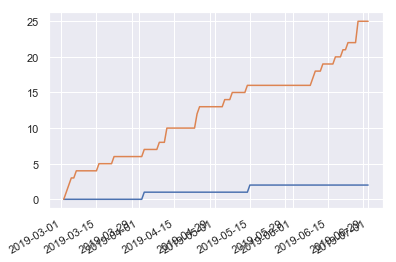

In [20]:
perf.take_profits.plot()
perf.stopped_out.plot()